Ce notebook vise à traiter les indices de secheresse SPEI pour la visualisation, la spatialisation. Nous y avons categorisé les types de secheresses (Extreme, Severe, ...), puis labelisé.

#### Importation des librairies

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from config import Config, Constant
from tabulate import tabulate
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#### Transposition de dataframe

In [2]:
def transposition_data(data, parametre):
    data_trans =data.melt(id_vars=['Date'], value_vars= data.columns[1:],var_name='Station',value_name=parametre)
    return data_trans

#### Changement de label de categorie de secheresse

In [3]:
def replace_text_with_one(data_df, target_text_1,target_text_2):
    dataframe = data_df.copy()    
    def replace_labels(value):
        if pd.notna(value) and value in  [target_text_1,target_text_2]:
            return '1'
        elif pd.notna(value):
            return '0'
        else:
            return value  # Garder les valeurs manquantes telles quelles    
    # Appliquer la fonction à la colonne 'Label Secheresse' en utilisant une fonction lambda
    dataframe['Label Secheresse'] = dataframe['Label Secheresse'].apply(lambda x: replace_labels(x))    
    return dataframe

In [4]:
# Définition de la fonction to_numeric_with_nan
def to_numeric_with_nan(value):
    try:
        return int(value)
    except (ValueError, TypeError):
        return pd.NA  # Retourne une valeur manquante

In [5]:
def filter_data_by_year_station(dataframe, year, station):
    year_str = str(year)  # Convertir l'année en chaîne de caractères
    filtered_df = dataframe.loc[(dataframe['Date'].astype(str).str.startswith(year_str)) & (dataframe['Station'] == station)]
    return filtered_df

#### Categorisation de la secheresse

In [6]:

# Définition de la fonction de catégorisation
def categorize_spei(spei_value):
    if np.isnan(spei_value):
        return np.nan  # Laisser les valeurs manquantes inchangées
    if spei_value >= 2.0:
        return Constant.LABEL_1   #"Extrêmement humide"
    elif 1.5 <= spei_value < 2.0:
        return Constant.LABEL_2   #"Très humide"
    elif 1.0 <= spei_value < 1.5:
        return Constant.LABEL_3   #"Modérément humide"
    elif -0.99 <= spei_value <= 0.99:
        return Constant.LABEL_4   #"Normal"
    elif -1.49 <= spei_value < -1.0:
        return Constant.LABEL_5   #"Sécheresse modérée"
    elif -1.99 <= spei_value < -1.5:
        return Constant.LABEL_6   #"Sécheresse sévère"
    else:
        return Constant.LABEL_7   #"Sécheresse extrême"

def categorize_drought(df):
    new_df = df.copy()
    new_df.iloc[:, 1:] = new_df.iloc[:, 1:].applymap(categorize_spei)
    return new_df        

#### Graphiques pour SPEI

### Occurence des apparutions de secheresse extreme et severe

In [7]:
def occurrences_secheresse(df_data, valeur1, valeur2):
    df = df_data.copy()
    occurrences_totales_par_station = {}

    stations = df.columns[1:]  # Exclure la colonne 'Date'
    for station in stations:
        # Initialiser les occurrences totales pour les deux valeurs
        occurrences_totales = 0
        # Compter les occurrences de valeur1 et valeur2 dans la colonne de la station
        station_counts = df[station].value_counts()
        if valeur1 in station_counts:
            occurrences_totales += station_counts[valeur1]
        if valeur2 in station_counts:
            occurrences_totales += station_counts[valeur2]
 
        # Stocker les occurrences totales dans le dictionnaire
        occurrences_totales_par_station[station] = occurrences_totales

    # Convertir le dictionnaire en DataFrame pour l'affichage
    resultat = pd.DataFrame(list(occurrences_totales_par_station.items()), columns=['Station', 'Occurrences Totales'])

    # Afficher le tableau formaté avec tabulate
    print(tabulate(resultat, headers='keys', tablefmt='pretty'))


In [8]:
def pourcentage_secheresse(df_data, valeur1, valeur2, nom_image):
    df = df_data.copy()
    occurrences_totales_par_station = {}

    stations = df.columns[1:]  # Exclure la colonne 'Date'
    for station in stations:
        # Initialiser les occurrences totales pour les deux valeurs
        occurrences_totales = 0
        # Compter les occurrences de valeur1 et valeur2 dans la colonne de la station
        station_counts = df[station].value_counts(normalize=True)
        if valeur1 in station_counts:
            occurrences_totales += station_counts[valeur1]
        if valeur2 in station_counts:
            occurrences_totales += station_counts[valeur2]
            
        occurrences_totales *=100
        round(occurrences_totales, 2)
        # Stocker les occurrences totales dans le dictionnaire
        occurrences_totales_par_station[station] = occurrences_totales

    # Convertir le dictionnaire en DataFrame pour l'affichage
    resultat = pd.DataFrame(list(occurrences_totales_par_station.items()), columns=['Station', 'Pourcentage de secheresse'])

    # Afficher le tableau formaté avec tabulate
    print(tabulate(resultat, headers='keys', tablefmt='pretty'))



### Occurence des apparutions de secheresse extreme et severe

In [9]:
def calculate_secheresse_percentage(df_data, secheresse_label_1, secheresse_label_2):
    df=df_data.copy()
    
    # Exclure la colonne 'Date' pour les calculs
    data = df.drop(columns=['Date'])

    # Comptage des occurrences pour chaque label de sécheresse
    count_secheresse_1 = data.apply(lambda x: x.astype(str).str.count(secheresse_label_1)).sum(axis=1)
    count_secheresse_2 = data.apply(lambda x: x.astype(str).str.count(secheresse_label_2)).sum(axis=1)

    # Comptage du nombre total de colonnes non manquantes par ligne
    total_non_missing = data.notna().sum(axis=1)

    # Calcul des pourcentages en gérant les valeurs manquantes
    pourcentage_1 = (count_secheresse_1 / total_non_missing) * 100
    pourcentage_2 = (count_secheresse_2 / total_non_missing) * 100

    # Ajout des pourcentages comme nouvelles colonnes
    df[f'Pourcentage {secheresse_label_1}'] = pourcentage_1
    df[f'Pourcentage {secheresse_label_2}'] = pourcentage_2
    df[f'Pourcentage Sécheresse extr_sev']=pourcentage_1+pourcentage_2

    # Sélection des colonnes 'Date' et les deux nouvelles colonnes
    selected_columns = ['Date', f'Pourcentage {secheresse_label_1}', f'Pourcentage {secheresse_label_2}',f'Pourcentage Sécheresse extr_sev']
    result_df = df[selected_columns]

    return result_df


#### Visualisation de la secheresse spatiale

In [10]:
def plot_drought_percentages(df_data, spei, freq='M'):
    df = df_data.copy()

    # Convertir la colonne 'Date' en un format de date
    if freq == 'M':
        date_format = '%Y%m'
    elif freq == 'D':
        date_format = '%Y%m%d'
    else:
        raise ValueError("La valeur de 'freq' doit être 'M' (mensuel) ou 'D' (décadaire)")

    # Convertir la colonne 'Date' en format de date
    df['Date'] = pd.to_datetime(df['Date'], format=date_format)

    # Trier le DataFrame par la colonne 'Date' si ce n'est pas déjà fait
    df = df.sort_values(by='Date')

    # Créer le graphe à barres
    plt.figure(figsize=(12, 6))  # Ajustez la taille de la figure selon vos besoins

    #plt.bar(df['Date'], df['Pourcentage Sécheresse extrême'], width=15, label='Extrême', color='red', alpha=0.7)
    #plt.bar(df['Date'], df['Pourcentage Sécheresse sévère'], width=15, label='Sévère', color='blue', alpha=0.7)
    plt.bar(df['Date'], df['Pourcentage Sécheresse extr_sev'], width=15, label='extr_sev', color='orange', alpha=0.7)
    plt.axhline(y=25, color='green', linestyle='--', label='')

    # Ajouter des étiquettes et des titres
    plt.xlabel('Date')
    plt.ylabel('Pourcentage')
    plt.title(f'{spei}: taux de stations avec Sécheresse Extrême et Sévère')
    plt.legend()

    # Personnaliser les étiquettes de l'axe x pour afficher toutes les quatre années
    plt.xticks(df['Date'][::60], df['Date'].dt.year[::60], rotation=45)

    # Afficher le graphe
    plt.tight_layout()  # Pour éviter que les étiquettes ne se chevauchent
    plt.show()


#### Visualisation de ECDF

In [11]:
def plot_ecdf(df_data,spei, freq='M'):
    
    df = df_data.copy()

    # Convertir la colonne 'Date' en un format de date
    if freq == 'M':
        date_format = '%Y%m'
    elif freq == 'D':
        date_format = '%Y%m%d'
    else:
        raise ValueError("La valeur de 'freq' doit être 'M' (mensuel) ou 'D' (décadaire)")
    
    # Convertir la colonne 'Date' en format de date
    df['Date'] = pd.to_datetime(df['Date'], format=date_format)
    
    # Supprimer les lignes avec des valeurs NaN dans les colonnes pertinentes
    df_data.dropna(subset=['Pourcentage Sécheresse extrême', 'Pourcentage Sécheresse sévère','Pourcentage Sécheresse extr_sev'], inplace=True)

    # Trier le dataframe par date (au cas où il ne le serait pas déjà)
    df_data.sort_values(by='Date', inplace=True)

    # Extraire les données pour les deux colonnes
    #data_extreme = df_data['Pourcentage Sécheresse extrême']
    #data_severe = df_data['Pourcentage Sécheresse sévère']
    data_extr_sev=df_data['Pourcentage Sécheresse extr_sev']

    # Calculer l'ECDF pour les données
    #x_extreme = np.sort(data_extreme)
    #y_extreme = np.arange(1, len(x_extreme) + 1) / len(x_extreme)

    #x_severe = np.sort(data_severe)
    #y_severe = np.arange(1, len(x_severe) + 1) / len(x_severe)
    
    x_extr_sev=np.sort(data_extr_sev)
    y_extr_sev=np.arange(1, len(x_extr_sev) +1)/ len(x_extr_sev)
    
    
    # Tracer la fonction de densité de probabilité (PDF) pour la colonne 'age'
    #sns.kdeplot(data_extreme, label='Sécheresse extrême', color='blue')

# Tracer la fonction de densité de probabilité (PDF) 
    #sns.kdeplot(data_severe, label='Sécheresse sévère', color='orange')
    
    sns.kdeplot(data_extr_sev, label='Sécheresse extr_sev', color='orange')
    
    

    # Tracer les résultats dans un même graphique en utilisant plt.plot
    plt.figure(figsize=(10, 6))
    #plt.plot(x_extreme, y_extreme, label='Sécheresse extrême', linestyle='--')
    #plt.plot(x_severe, y_severe, label='Sécheresse sévère', linestyle='-')
    
    plt.plot(x_extr_sev, y_extr_sev, label='Sécheresse extr_sev', linestyle='--',color='orange')

    
    
    plt.xlabel('Cohérence spatiale (%)')
    plt.ylabel('Probabilité Cumulative')
    plt.legend()
    plt.title(f'{spei}: ECDF des Pourcentages de Sécheresse')
    plt.grid(True)
    # Afficher le graphique
    plt.show()

#### Saison des pluies

In [12]:
#Lecture du fichier des dates de pluies
saison_pluie=pd.read_csv(os.path.join(Config.FILES_TRAITED_PATH,Config.STATION_ALL))

saison_pluie.sort_values(by=['Station', 'Year', 'Month','Decade','Day'], ascending=True, inplace=True)

#Saison des pluies mois
saison_pluie_mois=saison_pluie.drop_duplicates(subset=['Station', 'Year', 'Month'], keep='last')
saison_pluie_mois=saison_pluie_mois[['Station', 'Year', 'Month','Saison_Pluie']]
# Ajouter un zéro au début du mois si nécessaire et créer la colonne 'Date'
saison_pluie_mois['Date'] = saison_pluie_mois['Year'].astype(str) + saison_pluie_mois['Month'].apply(lambda x: str(x).zfill(2))
#Saison des pluies decades
saison_pluie_decade=saison_pluie.drop_duplicates(subset=['Station', 'Year', 'Month','Decade'], keep='last')
saison_pluie_decade=saison_pluie_decade[['Station', 'Year', 'Month','Decade','Saison_Pluie']]
# Ajouter un zéro au début du mois si nécessaire et créer la colonne 'Date'
saison_pluie_decade['Date'] = saison_pluie_decade['Year'].astype(str) + saison_pluie_decade['Month'].apply(lambda x: str(x).zfill(2))+ saison_pluie_decade['Decade'].apply(lambda x: str(x).zfill(2))

#### Filtre de dataframes pour controle

### I-SPEI DECADAIRE

#### I.1- Lecture des données de spei décadaires

In [13]:
# Lire les données de SPEI decadaires obtenu par CDT
spei_1dek=pd.read_csv(os.path.join(Config.SPEI_PATH, Config.SPEI_1DEK_FILE_NAME), encoding='ISO-8859-1')
# Remplacer les valeurs manquantes (-9999) par NaN pour le tracé correct
spei_1dek = spei_1dek.replace(-9999, np.nan)
# Appliquer la fonction categorize_drought
spei_1dek_categorized = categorize_drought(spei_1dek)

In [14]:
spei_1dek.shape, saison_pluie_decade.shape

((2268, 11), (22524, 6))

In [15]:
spei_1dek.head()

,Date,Bobo_Dioulasso,Bogande,Boromo,Dedougou,Dori,Fada_Ngourma,Gaoua,Ouagadougou_aero,Ouahigouya,Po
0,1961011,-1.286516,NaN,-1.857426,-0.659593,-1.461801,-1.791719,-0.898816,-2.252919,-1.529471,NaN
1,1961012,-0.376058,NaN,-1.232331,0.310330,-0.419377,-1.946089,-0.170445,-1.089744,-1.833779,NaN
2,1961013,-0.913858,NaN,-2.620046,-1.116355,-0.679334,-1.241127,-0.216929,-0.937901,-0.790746,NaN
3,1961021,-1.433058,NaN,-1.819489,-0.822601,-0.690049,-1.968888,-1.089515,-1.571175,-0.414243,NaN
4,1961022,-1.275861,NaN,-1.593449,-0.266155,-0.461867,-1.533451,-0.781104,-1.253965,-0.899830,NaN


In [16]:
spei_1dek.melt(id_vars=['Date'], value_vars=spei_1dek.columns[1:], var_name='Station',value_name='Nouveau')

,Date,Station,Nouveau
0,1961011,Bobo_Dioulasso,-1.286516
1,1961012,Bobo_Dioulasso,-0.376058
2,1961013,Bobo_Dioulasso,-0.913858
3,1961021,Bobo_Dioulasso,-1.433058
4,1961022,Bobo_Dioulasso,-1.275861
...,...,...,...
22675,2023112,Po,-3.045372
22676,2023113,Po,-0.711262
22677,2023121,Po,-2.288330
22678,2023122,Po,-2.055077


In [17]:
spei_1dek.shape, saison_pluie_decade.shape

((2268, 11), (22524, 6))

In [18]:
22680-22524

156

In [19]:
spei_1dek_categorized.head()

,Date,Bobo_Dioulasso,Bogande,Boromo,Dedougou,Dori,Fada_Ngourma,Gaoua,Ouagadougou_aero,Ouahigouya,Po
0,1961011,Sécheresse modérée,NaN,Sécheresse sévère,Normale,Sécheresse modérée,Sécheresse sévère,Normale,Sécheresse extrême,Sécheresse sévère,NaN
1,1961012,Normale,NaN,Sécheresse modérée,Normale,Normale,Sécheresse sévère,Normale,Sécheresse modérée,Sécheresse sévère,NaN
2,1961013,Normale,NaN,Sécheresse extrême,Sécheresse modérée,Normale,Sécheresse modérée,Normale,Normale,Normale,NaN
3,1961021,Sécheresse modérée,NaN,Sécheresse sévère,Normale,Normale,Sécheresse sévère,Sécheresse modérée,Sécheresse sévère,Normale,NaN
4,1961022,Sécheresse modérée,NaN,Sécheresse sévère,Normale,Normale,Sécheresse sévère,Normale,Sécheresse modérée,Normale,NaN


In [20]:
occurrences_secheresse(spei_1dek_categorized, Constant.LABEL_7, Constant.LABEL_6)

+---+------------------+---------------------+
|   |     Station      | Occurrences Totales |
+---+------------------+---------------------+
| 0 |  Bobo_Dioulasso  |         127         |
| 1 |     Bogande      |         57          |
| 2 |      Boromo      |         163         |
| 3 |     Dedougou     |         141         |
| 4 |       Dori       |         160         |
| 5 |   Fada_Ngourma   |         148         |
| 6 |      Gaoua       |         155         |
| 7 | Ouagadougou_aero |         163         |
| 8 |    Ouahigouya    |         158         |
| 9 |        Po        |         96          |
+---+------------------+---------------------+
+---+------------------+---------------------+
|   |     Station      | Occurrences Totales |
+---+------------------+---------------------+
| 0 |  Bobo_Dioulasso  |         127         |
| 1 |     Bogande      |         57          |
| 2 |      Boromo      |         163         |
| 3 |     Dedougou     |         141         |
| 4 |       D

In [21]:
pourcentage_secheresse(spei_1dek_categorized, Constant.LABEL_7, Constant.LABEL_6, 'decade')

+---+------------------+---------------------------+
|   |     Station      | Pourcentage de secheresse |
+---+------------------+---------------------------+
| 0 |  Bobo_Dioulasso  |     5.731046931407942     |
| 1 |     Bogande      |     6.447963800904977     |
| 2 |      Boromo      |     7.280035730236713     |
| 3 |     Dedougou     |     6.601123595505618     |
| 4 |       Dori       |     7.373271889400922     |
| 5 |   Fada_Ngourma   |     6.636771300448431     |
| 6 |      Gaoua       |     6.969424460431655     |
| 7 | Ouagadougou_aero |     7.312696276357111     |
| 8 |    Ouahigouya    |     7.050423917893797     |
| 9 |        Po        |     6.847360912981455     |
+---+------------------+---------------------------+
+---+------------------+---------------------------+
|   |     Station      | Pourcentage de secheresse |
+---+------------------+---------------------------+
| 0 |  Bobo_Dioulasso  |     5.731046931407942     |
| 1 |     Bogande      |     6.447963800904977

#### I.2 - Graphes pour le SPEI decadaire

#### I.3- Secheresse spatiale

##### I.3.a - Calcul secheresse spatiale

In [22]:
spei_1dek_spatial = calculate_secheresse_percentage(spei_1dek_categorized, Constant.LABEL_7, Constant.LABEL_6)
# Affichage
spei_1dek_spatial.head()

,Date,Pourcentage Sécheresse extrême,Pourcentage Sécheresse sévère,Pourcentage Sécheresse extr_sev
0,1961011,12.5,37.5,50.0
1,1961012,0.0,25.0,25.0
2,1961013,12.5,0.0,12.5
3,1961021,0.0,37.5,37.5
4,1961022,0.0,25.0,25.0


In [23]:
spei_1dek_spatial.shape

(2268, 4)

In [24]:
# Trouvez l'indice de la ligne avec la valeur maximale dans 'Pourcentage Sécheresse'
indice_ligne_max_secheresse = spei_1dek_spatial[f'Pourcentage {Constant.LABEL_II}'].idxmax()
# Obtenez la ligne correspondante à cet indice
ligne_max_secheresse = spei_1dek_spatial.loc[indice_ligne_max_secheresse]
# Maintenant, ligne_max_secheresse_extreme contient la ligne avec la plus haute valeur dans 'Pourcentage Sécheresse extrême'
print(ligne_max_secheresse)

Date                               2023042.0
Pourcentage Sécheresse extrême          75.0
Pourcentage Sécheresse sévère           25.0
Pourcentage Sécheresse extr_sev        100.0
Name: 2242, dtype: float64
Date                               2023042.0
Pourcentage Sécheresse extrême          75.0
Pourcentage Sécheresse sévère           25.0
Pourcentage Sécheresse extr_sev        100.0
Name: 2242, dtype: float64


##### I.3.b - Visualisation secheresse spatiale

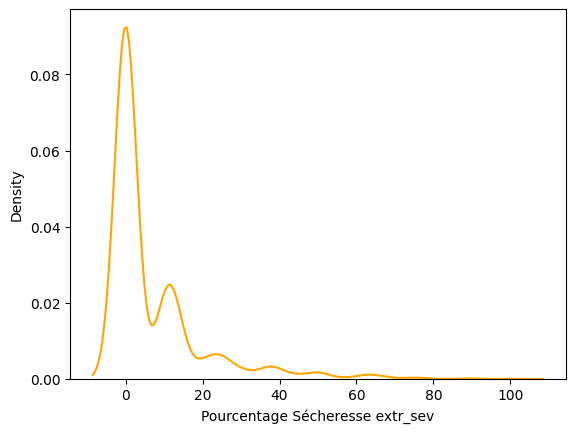

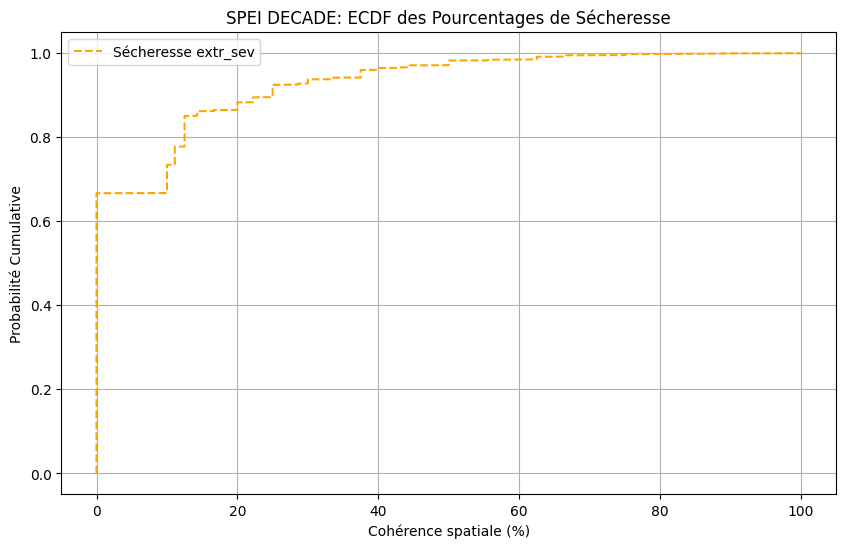

In [25]:
plot_ecdf(spei_1dek_spatial,'SPEI DECADE', freq='D')

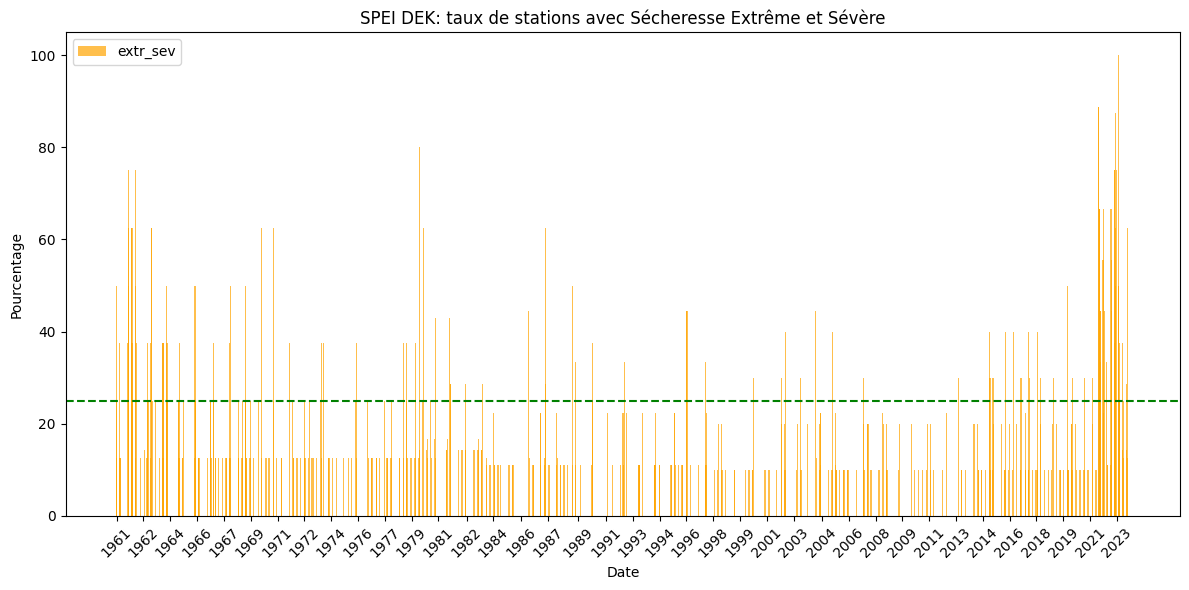

In [26]:
plot_drought_percentages(spei_1dek_spatial,'SPEI DEK',freq='D')

#### I.4- Label des secheresses

In [27]:
spei_1dek_saison=transposition_data(spei_1dek_categorized,'Label Secheresse')

In [28]:
spei_1dek_saison.head()

,Date,Station,Label Secheresse
0,1961011,Bobo_Dioulasso,Sécheresse modérée
1,1961012,Bobo_Dioulasso,Normale
2,1961013,Bobo_Dioulasso,Normale
3,1961021,Bobo_Dioulasso,Sécheresse modérée
4,1961022,Bobo_Dioulasso,Sécheresse modérée


In [29]:
spei_1dek_saison.shape

(22680, 3)

In [30]:
saison_pluie_decade.head()

,Station,Year,Month,Decade,Saison_Pluie,Date
9,Bobo_Dioulasso,1961,1,1,False,19610101
19,Bobo_Dioulasso,1961,1,2,False,19610102
30,Bobo_Dioulasso,1961,1,3,False,19610103
40,Bobo_Dioulasso,1961,2,1,False,19610201
50,Bobo_Dioulasso,1961,2,2,False,19610202


In [31]:
spei_1dek_saison['Date'] = pd.to_datetime(spei_1dek_saison['Date'], format='%Y%m%d')
saison_pluie_decade['Date'] = pd.to_datetime(saison_pluie_decade['Date'], format='%Y%m%d')
spei_1dek_fusion = pd.merge(spei_1dek_saison, saison_pluie_decade, on=['Date','Station'], how='outer')

In [32]:
spei_1dek_fusion.shape

(22680, 7)

In [33]:
spei_1dek_fusion[['Year', 'Month', 'Decade']] = spei_1dek_fusion[['Year', 'Month', 'Decade']].applymap(to_numeric_with_nan)


In [34]:
spei_1dek_fusion.head()

,Date,Station,Label Secheresse,Year,Month,Decade,Saison_Pluie
0,1961-01-01,Bobo_Dioulasso,Sécheresse modérée,1961,1,1,False
1,1961-01-01,Bogande,NaN,1961,1,1,False
2,1961-01-01,Boromo,Sécheresse sévère,1961,1,1,False
3,1961-01-01,Dedougou,Normale,1961,1,1,False
4,1961-01-01,Dori,Sécheresse modérée,1961,1,1,False


##### I.4.a- Secheresse extreme

In [35]:
spei_1dek_extr_sev = replace_text_with_one(spei_1dek_fusion, Constant.LABEL_7, Constant.LABEL_6)

In [36]:
spei_1dek_extr_sev.shape

(22680, 7)

In [37]:
spei_1dek_extr_sev.to_csv(os.path.join(Config.FILES_TRAITED_PATH,Config.DATA_1DEK),index=False)

In [38]:
filtered_Bobo_1992 = filter_data_by_year_station(spei_1dek_extr_sev, 1992, 'Bobo_Dioulasso')

In [39]:
filtered_Bobo_1992.head()

,Date,Station,Label Secheresse,Year,Month,Decade,Saison_Pluie
11160,1992-01-01,Bobo_Dioulasso,0,1992,1,1,False
11170,1992-01-02,Bobo_Dioulasso,0,1992,1,2,False
11180,1992-01-03,Bobo_Dioulasso,0,1992,1,3,False
11190,1992-02-01,Bobo_Dioulasso,0,1992,2,1,False
11200,1992-02-02,Bobo_Dioulasso,0,1992,2,2,False


##### Zoom sur la secheresse extreme

In [40]:
#process_and_plot_data(spei_1dek,'D',-2)
#process_and_plot_data(spei_1dek, 'D', Constant.SEUIL_4)

### II-SPEI MENSUEL

#### II.1- Lecture des données de spei mensuel

In [41]:
# Lire les données de SPEI mensuelles obtenu par CDT
#spei_1mois=pd.read_csv('../DATA/DATA_SPEI/SPEI_1mon.csv',encoding='ISO-8859-1')
spei_1mois=pd.read_csv(str(Config.SPEI_PATH) + '/' + str(Config.SPEI_1MON_FILE_NAME),encoding='ISO-8859-1')
# Remplacer les valeurs manquantes (-9999) par NaN pour le tracé correct
spei_1mois = spei_1mois.replace(-9999, np.nan)
spei_1mois_categorized = categorize_drought(spei_1mois)

In [42]:
spei_1mois.head()

,Date,Bobo_Dioulasso,Bogande,Boromo,Dedougou,Dori,Fada_Ngourma,Gaoua,Ouagadougou_aero,Ouahigouya,Po
0,196101,-1.000704,NaN,-2.034081,-0.710341,-0.992456,-1.713908,-0.634162,-1.878780,-1.518232,NaN
1,196102,-1.393686,NaN,-1.804325,-0.612409,-0.706352,-1.820190,-1.150189,-1.751562,-0.763708,NaN
2,196103,-0.839564,NaN,-1.845435,-0.339384,-0.539231,-1.631550,0.085456,-1.600283,-0.378648,NaN
3,196104,0.829207,NaN,-0.285622,0.410055,-1.520207,-0.465427,0.189532,-0.448510,-1.165458,NaN
4,196105,-0.201688,NaN,-1.227589,-0.051327,0.706801,0.353970,0.001122,-0.823735,-0.590157,NaN


In [43]:
spei_1mois_categorized.head()

,Date,Bobo_Dioulasso,Bogande,Boromo,Dedougou,Dori,Fada_Ngourma,Gaoua,Ouagadougou_aero,Ouahigouya,Po
0,196101,Sécheresse modérée,NaN,Sécheresse extrême,Normale,Sécheresse extrême,Sécheresse sévère,Normale,Sécheresse sévère,Sécheresse sévère,NaN
1,196102,Sécheresse modérée,NaN,Sécheresse sévère,Normale,Normale,Sécheresse sévère,Sécheresse modérée,Sécheresse sévère,Normale,NaN
2,196103,Normale,NaN,Sécheresse sévère,Normale,Normale,Sécheresse sévère,Normale,Sécheresse sévère,Normale,NaN
3,196104,Normale,NaN,Normale,Normale,Sécheresse sévère,Normale,Normale,Normale,Sécheresse modérée,NaN
4,196105,Normale,NaN,Sécheresse modérée,Normale,Normale,Normale,Normale,Normale,Normale,NaN


In [44]:
occurrences_secheresse(spei_1mois_categorized, Constant.LABEL_7, Constant.LABEL_6)

+---+------------------+---------------------+
|   |     Station      | Occurrences Totales |
+---+------------------+---------------------+
| 0 |  Bobo_Dioulasso  |         51          |
| 1 |     Bogande      |         17          |
| 2 |      Boromo      |         55          |
| 3 |     Dedougou     |         57          |
| 4 |       Dori       |         60          |
| 5 |   Fada_Ngourma   |         53          |
| 6 |      Gaoua       |         53          |
| 7 | Ouagadougou_aero |         52          |
| 8 |    Ouahigouya    |         50          |
| 9 |        Po        |         33          |
+---+------------------+---------------------+
+---+------------------+---------------------+
|   |     Station      | Occurrences Totales |
+---+------------------+---------------------+
| 0 |  Bobo_Dioulasso  |         51          |
| 1 |     Bogande      |         17          |
| 2 |      Boromo      |         55          |
| 3 |     Dedougou     |         57          |
| 4 |       D

In [45]:
pourcentage_secheresse(spei_1mois_categorized, Constant.LABEL_7, Constant.LABEL_6, 'mois')

+---+------------------+---------------------------+
|   |     Station      | Pourcentage de secheresse |
+---+------------------+---------------------------+
| 0 |  Bobo_Dioulasso  |     6.986301369863014     |
| 1 |     Bogande      |     5.782312925170068     |
| 2 |      Boromo      |    7.4324324324324325     |
| 3 |     Dedougou     |     8.05084745762712      |
| 4 |       Dori       |     8.344923504867872     |
| 5 |   Fada_Ngourma   |     7.240437158469945     |
| 6 |      Gaoua       |     7.290233837689134     |
| 7 | Ouagadougou_aero |     7.103825136612022     |
| 8 |    Ouahigouya    |     6.738544474393532     |
| 9 |        Po        |     7.173913043478261     |
+---+------------------+---------------------------+
+---+------------------+---------------------------+
|   |     Station      | Pourcentage de secheresse |
+---+------------------+---------------------------+
| 0 |  Bobo_Dioulasso  |     6.986301369863014     |
| 1 |     Bogande      |     5.782312925170068

#### II.2 - Graphes pour le SPEI mensuel

In [46]:
# Utilisation de la fonction avec votre DataFrame spei_1mois
#plot_spei_for_stations(spei_1mois, freq='M')

#### II.3- Secheresse spatiale

##### II.3.a - Calcul secheresse spatiale

In [47]:
spei_1mois_spatial = calculate_secheresse_percentage(spei_1mois_categorized, Constant.LABEL_7, Constant.LABEL_6)
# Affichage de la DataFrame mise à jour
spei_1mois_spatial.head()

,Date,Pourcentage Sécheresse extrême,Pourcentage Sécheresse sévère,Pourcentage Sécheresse extr_sev
0,196101,25.0,37.5,62.5
1,196102,0.0,37.5,37.5
2,196103,0.0,37.5,37.5
3,196104,0.0,12.5,12.5
4,196105,0.0,0.0,0.0


In [48]:
#spei_1mois_spatial.to_csv('../DATA/spei_1mois_spatial.xlsx')

##### II.3.b - Visualisation secheresse spatiale

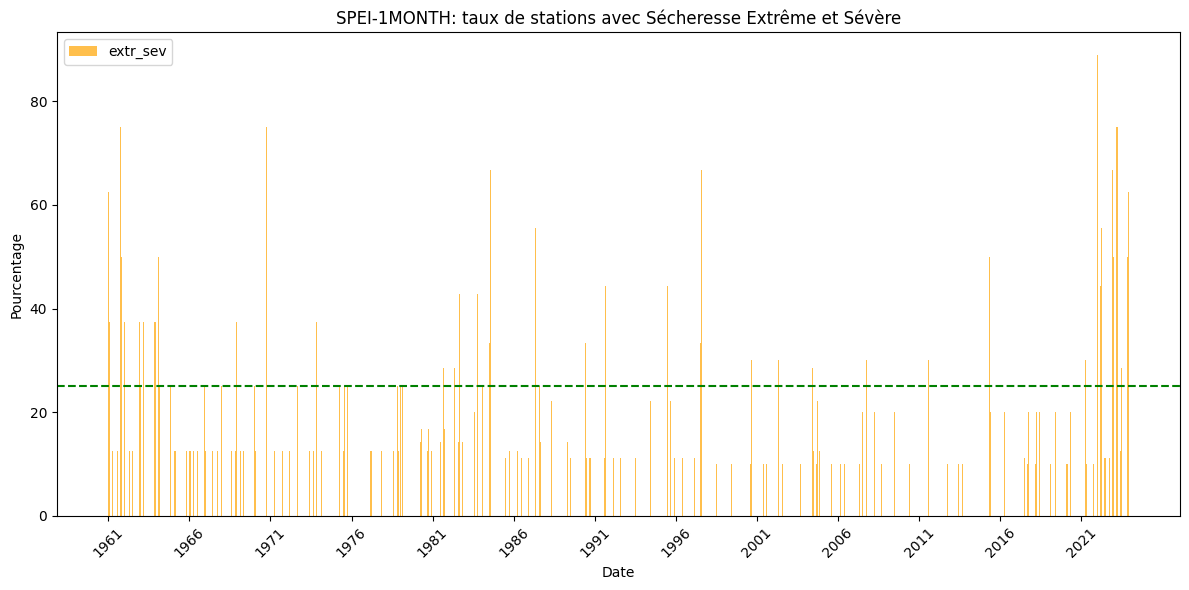

In [49]:
plot_drought_percentages(spei_1mois_spatial,'SPEI-1MONTH')

In [50]:
# Trouvez l'indice de la ligne avec la valeur maximale dans 'Pourcentage Sécheresse extrême'
indice_ligne_max_secheresse = spei_1mois_spatial[f'Pourcentage {Constant.LABEL_II}'].idxmax()
# Obtenez la ligne correspondante à cet indice
ligne_max_secheresse = spei_1mois_spatial.loc[indice_ligne_max_secheresse]
# Maintenant, ligne_max_secheresse_extreme contient la ligne avec la plus haute valeur dans 'Pourcentage Sécheresse extrême'
print(ligne_max_secheresse)

Date                               202201.000000
Pourcentage Sécheresse extrême         55.555556
Pourcentage Sécheresse sévère          33.333333
Pourcentage Sécheresse extr_sev        88.888889
Name: 732, dtype: float64
Date                               202201.000000
Pourcentage Sécheresse extrême         55.555556
Pourcentage Sécheresse sévère          33.333333
Pourcentage Sécheresse extr_sev        88.888889
Name: 732, dtype: float64


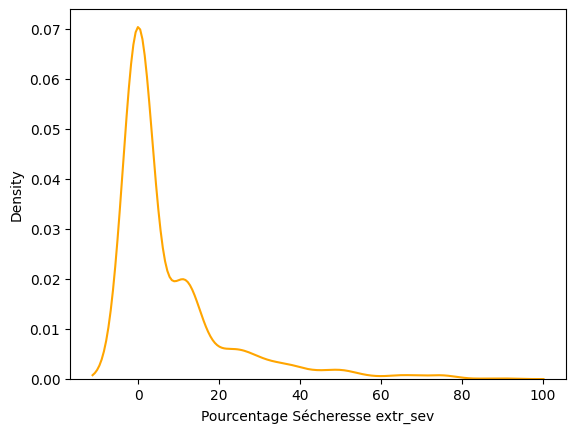

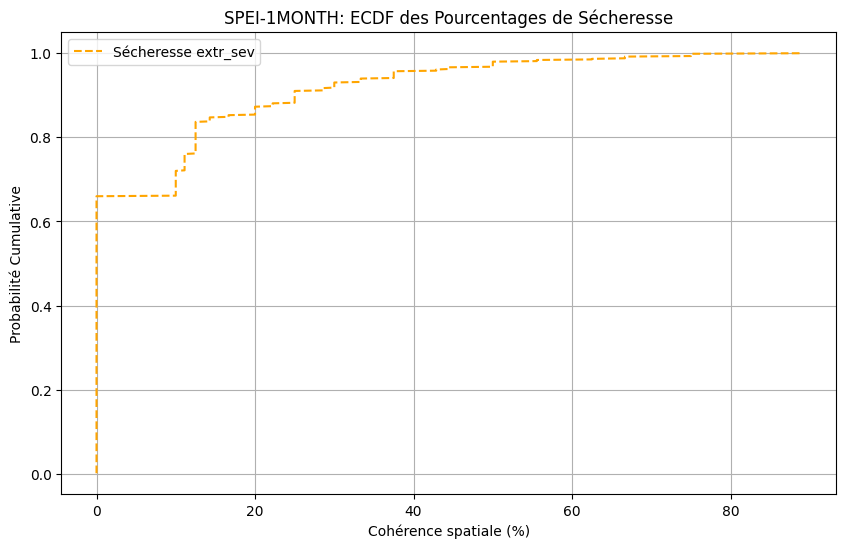

In [51]:
plot_ecdf(spei_1mois_spatial,'SPEI-1MONTH')

#### II.4- Label des secheresses

In [52]:
spei_1mois_saison=transposition_data(spei_1mois_categorized,'Label Secheresse')

In [53]:
spei_1mois_saison['Date'] = pd.to_datetime(spei_1mois_saison['Date'], format='%Y%m')
saison_pluie_mois['Date'] = pd.to_datetime(saison_pluie_mois['Date'], format='%Y%m')

spei_1mois_fusion = pd.merge(spei_1mois_saison, saison_pluie_mois, on=['Date', 'Station'], how='outer')
spei_1mois_fusion=spei_1mois_fusion[['Station','Date','Label Secheresse','Saison_Pluie','Year','Month']]

In [54]:
spei_1mois_fusion[['Year', 'Month']] = spei_1mois_fusion[['Year', 'Month']].applymap(to_numeric_with_nan)


In [55]:
spei_1mois_fusion

,Station,Date,Label Secheresse,Saison_Pluie,Year,Month
0,Bobo_Dioulasso,1961-01-01,Sécheresse modérée,False,1961,1
1,Bogande,1961-01-01,NaN,False,1961,1
2,Boromo,1961-01-01,Sécheresse extrême,False,1961,1
3,Dedougou,1961-01-01,Normale,False,1961,1
4,Dori,1961-01-01,Sécheresse extrême,False,1961,1
...,...,...,...,...,...,...
7555,Fada_Ngourma,2023-12-01,Sécheresse sévère,False,2023,12
7556,Gaoua,2023-12-01,Normale,False,2023,12
7557,Ouagadougou_aero,2023-12-01,Normale,False,2023,12
7558,Ouahigouya,2023-12-01,Sécheresse extrême,False,2023,12


##### II.4.a- Secheresse extreme

In [56]:
spei_1mois_extr_sev = replace_text_with_one(spei_1mois_fusion,  Constant.LABEL_7, Constant.LABEL_6)

In [57]:
spei_1mois_extr_sev.to_csv(os.path.join(Config.FILES_TRAITED_PATH, Config.DATA_1MON),index=False)

In [58]:
filtered_Bobo_1992 = filter_data_by_year_station(spei_1mois_extr_sev, 1992, 'Bobo_Dioulasso')

In [59]:
spei_1mois.head()

,Date,Bobo_Dioulasso,Bogande,Boromo,Dedougou,Dori,Fada_Ngourma,Gaoua,Ouagadougou_aero,Ouahigouya,Po
0,196101,-1.000704,NaN,-2.034081,-0.710341,-0.992456,-1.713908,-0.634162,-1.878780,-1.518232,NaN
1,196102,-1.393686,NaN,-1.804325,-0.612409,-0.706352,-1.820190,-1.150189,-1.751562,-0.763708,NaN
2,196103,-0.839564,NaN,-1.845435,-0.339384,-0.539231,-1.631550,0.085456,-1.600283,-0.378648,NaN
3,196104,0.829207,NaN,-0.285622,0.410055,-1.520207,-0.465427,0.189532,-0.448510,-1.165458,NaN
4,196105,-0.201688,NaN,-1.227589,-0.051327,0.706801,0.353970,0.001122,-0.823735,-0.590157,NaN


### III-SPEI TRIMENSUEL

#### III.1- Lecture des données de spei trimensuel

In [60]:
# Lire les données de SPEI trimestriel obtenu par CDT
spei_3mois=pd.read_csv(os.path.join(Config.SPEI_PATH, Config.SPEI_3MON_FILE_NAME),encoding='ISO-8859-1')
# Remplacer les valeurs manquantes (-9999) par NaN pour le tracé correct
spei_3mois = spei_3mois.replace(-9999, np.nan)
spei_3mois_categorized = categorize_drought(spei_3mois)

In [61]:
spei_3mois.head()

,Date,Bobo_Dioulasso,Bogande,Boromo,Dedougou,Dori,Fada_Ngourma,Gaoua,Ouagadougou_aero,Ouahigouya,Po
0,196103,-1.217309,0.937252,-1.938804,-0.479372,-0.772427,-1.799361,-0.737548,-1.978376,-0.868810,1.291183
1,196104,-0.570503,0.932121,-1.801831,-0.263635,-0.901531,-1.530456,-0.422930,-1.341339,-0.782260,1.283215
2,196105,-0.159744,0.934991,-1.903031,-0.075171,-0.551622,-0.862626,-0.075815,-1.190111,-0.872948,1.274550
3,196106,0.399637,0.908307,-0.487400,0.079347,0.635509,0.783264,0.818070,0.482002,-0.753970,1.184615
4,196107,1.117915,0.801820,-0.655785,0.967571,1.298356,2.227849,0.431482,0.450459,1.041051,0.255169


In [62]:
spei_3mois_categorized.head()

,Date,Bobo_Dioulasso,Bogande,Boromo,Dedougou,Dori,Fada_Ngourma,Gaoua,Ouagadougou_aero,Ouahigouya,Po
0,196103,Sécheresse modérée,Normale,Sécheresse sévère,Normale,Normale,Sécheresse sévère,Normale,Sécheresse sévère,Normale,Humidité modérée
1,196104,Normale,Normale,Sécheresse sévère,Normale,Normale,Sécheresse sévère,Normale,Sécheresse modérée,Normale,Humidité modérée
2,196105,Normale,Normale,Sécheresse sévère,Normale,Normale,Normale,Normale,Sécheresse modérée,Normale,Humidité modérée
3,196106,Normale,Normale,Normale,Normale,Normale,Normale,Normale,Normale,Normale,Humidité modérée
4,196107,Humidité modérée,Normale,Normale,Normale,Humidité modérée,Humidité extrême,Normale,Normale,Humidité modérée,Normale


In [63]:
occurrences_secheresse(spei_3mois_categorized, Constant.LABEL_7, Constant.LABEL_6)

+---+------------------+---------------------+
|   |     Station      | Occurrences Totales |
+---+------------------+---------------------+
| 0 |  Bobo_Dioulasso  |         47          |
| 1 |     Bogande      |         64          |
| 2 |      Boromo      |         52          |
| 3 |     Dedougou     |         54          |
| 4 |       Dori       |         46          |
| 5 |   Fada_Ngourma   |         54          |
| 6 |      Gaoua       |         52          |
| 7 | Ouagadougou_aero |         57          |
| 8 |    Ouahigouya    |         58          |
| 9 |        Po        |         26          |
+---+------------------+---------------------+
+---+------------------+---------------------+
|   |     Station      | Occurrences Totales |
+---+------------------+---------------------+
| 0 |  Bobo_Dioulasso  |         47          |
| 1 |     Bogande      |         64          |
| 2 |      Boromo      |         52          |
| 3 |     Dedougou     |         54          |
| 4 |       D

In [64]:
pourcentage_secheresse(spei_3mois_categorized, Constant.LABEL_7, Constant.LABEL_6, 'trimestre')

+---+------------------+---------------------------+
|   |     Station      | Pourcentage de secheresse |
+---+------------------+---------------------------+
| 0 |  Bobo_Dioulasso  |     6.233421750663131     |
| 1 |     Bogande      |     8.488063660477453     |
| 2 |      Boromo      |     6.896551724137931     |
| 3 |     Dedougou     |     7.161803713527852     |
| 4 |       Dori       |     6.10079575596817      |
| 5 |   Fada_Ngourma   |     7.161803713527851     |
| 6 |      Gaoua       |     6.896551724137931     |
| 7 | Ouagadougou_aero |    7.5596816976127315     |
| 8 |    Ouahigouya    |    7.6923076923076925     |
| 9 |        Po        |    3.4482758620689653     |
+---+------------------+---------------------------+
+---+------------------+---------------------------+
|   |     Station      | Pourcentage de secheresse |
+---+------------------+---------------------------+
| 0 |  Bobo_Dioulasso  |     6.233421750663131     |
| 1 |     Bogande      |     8.488063660477453

#### III.2 - Graphes pour le SPEI trimestriel

#### III.3- Secheresse spatiale

##### III.3.a - Calcul secheresse spatiale

In [65]:
spei_3mois_spatial = calculate_secheresse_percentage(spei_3mois_categorized, Constant.LABEL_7, Constant.LABEL_6)
# Affichage de la DataFrame mise à jour
spei_3mois_spatial.head()

,Date,Pourcentage Sécheresse extrême,Pourcentage Sécheresse sévère,Pourcentage Sécheresse extr_sev
0,196103,0.0,30.0,30.0
1,196104,0.0,20.0,20.0
2,196105,0.0,10.0,10.0
3,196106,0.0,0.0,0.0
4,196107,0.0,0.0,0.0


##### III.3.b - Visualisation secheresse spatiale

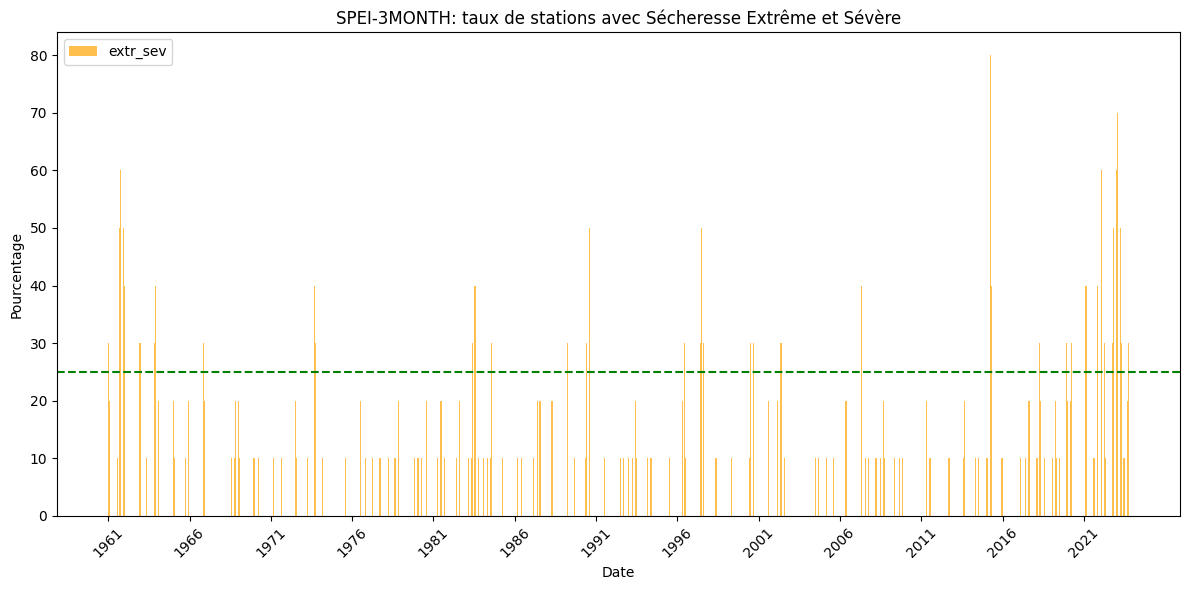

In [66]:
plot_drought_percentages(spei_3mois_spatial,'SPEI-3MONTH')

In [67]:
# Trouvez l'indice de la ligne avec la valeur maximale dans 'Pourcentage Sécheresse extrême'
indice_ligne_max_secheresse = spei_3mois_spatial[f'Pourcentage {Constant.LABEL_II}'].idxmax()
# Obtenez la ligne correspondante à cet indice
ligne_max_secheresse = spei_3mois_spatial.loc[indice_ligne_max_secheresse]
# Maintenant, ligne_max_secheresse_extreme contient la ligne avec la plus haute valeur dans 'Pourcentage Sécheresse extrême'
print(ligne_max_secheresse)

Date                               201506.0
Pourcentage Sécheresse extrême         30.0
Pourcentage Sécheresse sévère          50.0
Pourcentage Sécheresse extr_sev        80.0
Name: 651, dtype: float64
Date                               201506.0
Pourcentage Sécheresse extrême         30.0
Pourcentage Sécheresse sévère          50.0
Pourcentage Sécheresse extr_sev        80.0
Name: 651, dtype: float64


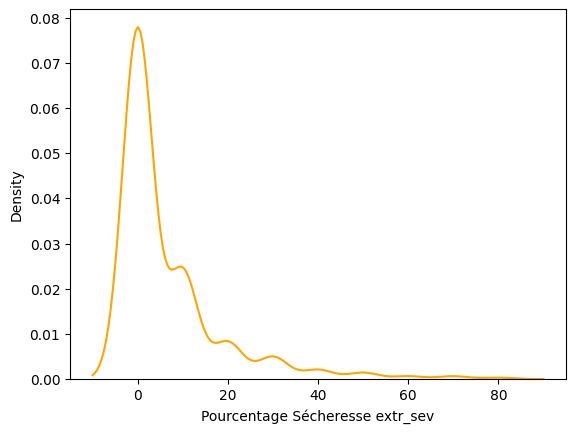

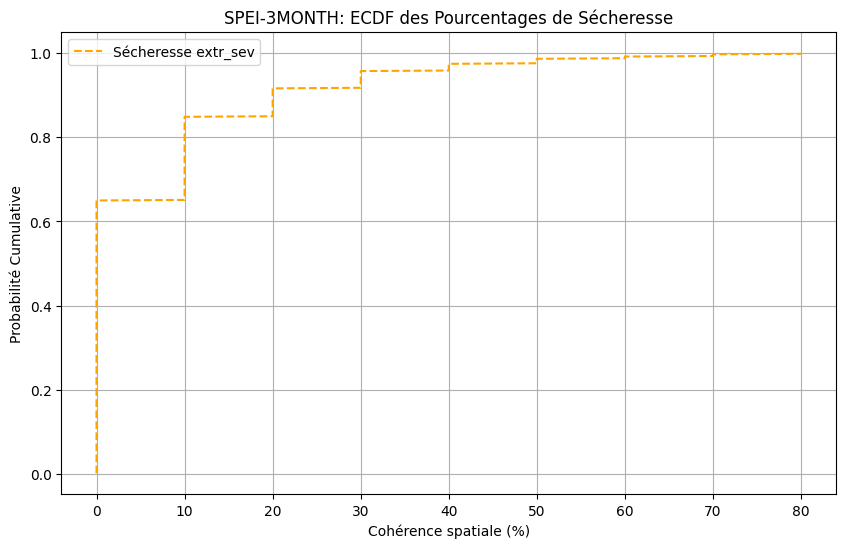

In [68]:
plot_ecdf(spei_3mois_spatial,'SPEI-3MONTH')

#### III.4- Label des secheresses

In [69]:
spei_3mois_saison=transposition_data(spei_3mois_categorized,'Label Secheresse')
spei_3mois_saison

,Date,Station,Label Secheresse
0,196103,Bobo_Dioulasso,Sécheresse modérée
1,196104,Bobo_Dioulasso,Normale
2,196105,Bobo_Dioulasso,Normale
3,196106,Bobo_Dioulasso,Normale
4,196107,Bobo_Dioulasso,Humidité modérée
...,...,...,...
7535,202308,Po,Normale
7536,202309,Po,Normale
7537,202310,Po,Normale
7538,202311,Po,Sécheresse modérée


In [70]:
spei_3mois_saison['Date'] = pd.to_datetime(spei_3mois_saison['Date'], format='%Y%m')
saison_pluie_mois['Date'] = pd.to_datetime(saison_pluie_mois['Date'], format='%Y%m')

spei_3mois_fusion = pd.merge(spei_3mois_saison, saison_pluie_mois, on=['Date', 'Station'], how='outer')
spei_3mois_fusion=spei_3mois_fusion[['Station','Date','Label Secheresse','Saison_Pluie','Year','Month']]
spei_3mois_fusion[['Year', 'Month']] = spei_3mois_fusion[['Year', 'Month']].applymap(to_numeric_with_nan)


##### III.4.a- Secheresse extreme

In [71]:
spei_3mois_extr_sev = replace_text_with_one(spei_3mois_fusion,  Constant.LABEL_7, Constant.LABEL_6)

In [72]:
spei_3mois_extr_sev

,Station,Date,Label Secheresse,Saison_Pluie,Year,Month
0,Bobo_Dioulasso,1961-01-01,NaN,False,1961,1
1,Bogande,1961-01-01,NaN,False,1961,1
2,Boromo,1961-01-01,NaN,False,1961,1
3,Dedougou,1961-01-01,NaN,False,1961,1
4,Dori,1961-01-01,NaN,False,1961,1
...,...,...,...,...,...,...
7555,Fada_Ngourma,2023-12-01,1,False,2023,12
7556,Gaoua,2023-12-01,0,False,2023,12
7557,Ouagadougou_aero,2023-12-01,0,False,2023,12
7558,Ouahigouya,2023-12-01,1,False,2023,12


In [73]:
spei_3mois_extr_sev.to_csv(str(Config.FILES_TRAITED_PATH) + '/' + str(Config.DATA_3MON),index=False)

In [74]:
spei_3mois_extr_sev.columns

Index(['Station', 'Date', 'Label Secheresse', 'Saison_Pluie', 'Year', 'Month'], dtype='object')

In [75]:
filtered_Bobo_1992 = filter_data_by_year_station(spei_3mois_extr_sev, 1992, 'Bobo_Dioulasso')

In [76]:
filtered_Bobo_1992.head()

,Station,Date,Label Secheresse,Saison_Pluie,Year,Month
3720,Bobo_Dioulasso,1992-01-01,0,False,1992,1
3730,Bobo_Dioulasso,1992-02-01,0,False,1992,2
3740,Bobo_Dioulasso,1992-03-01,0,False,1992,3
3750,Bobo_Dioulasso,1992-04-01,0,True,1992,4
3760,Bobo_Dioulasso,1992-05-01,0,True,1992,5


### IV-SPEI SEMESTRIEL

#### IV.1- Lecture des données de spei semestriel

In [77]:
# Lire les données de SPEI mensuelles obtenu par CDT
spei_6mois=pd.read_csv(os.path.join(Config.SPEI_PATH,Config.SPEI_6MON_FILE_NAME),encoding='ISO-8859-1')
# Remplacer les valeurs manquantes (-9999) par NaN pour le tracé correct
spei_6mois = spei_6mois.replace(-9999, np.nan)
spei_6mois_categorized = categorize_drought(spei_6mois)

In [78]:
spei_6mois.head()

,Date,Bobo_Dioulasso,Bogande,Boromo,Dedougou,Dori,Fada_Ngourma,Gaoua,Ouagadougou_aero,Ouahigouya,Po
0,196106,-0.568914,0.928077,-2.241733,-0.293037,-0.343199,-0.938125,0.050671,-0.515851,-1.121373,1.296408
1,196107,0.443667,0.911568,-1.803957,0.393832,0.229768,0.857386,-0.114557,-0.449512,0.167933,1.248830
2,196108,1.069880,0.909573,-1.644100,0.722516,1.310745,1.502228,0.318576,-0.079036,1.026563,0.760134
3,196109,1.299273,0.876778,-1.407110,0.720162,1.382453,1.543948,0.027064,0.468031,0.998624,-0.106764
4,196110,0.924457,0.878820,-1.676493,0.442323,1.321520,1.297374,-0.621535,0.208708,0.635385,-0.227359


In [79]:
spei_6mois_categorized.head()

,Date,Bobo_Dioulasso,Bogande,Boromo,Dedougou,Dori,Fada_Ngourma,Gaoua,Ouagadougou_aero,Ouahigouya,Po
0,196106,Normale,Normale,Sécheresse extrême,Normale,Normale,Normale,Normale,Normale,Sécheresse modérée,Humidité modérée
1,196107,Normale,Normale,Sécheresse sévère,Normale,Normale,Normale,Normale,Normale,Normale,Humidité modérée
2,196108,Humidité modérée,Normale,Sécheresse sévère,Normale,Humidité modérée,Humidité sévère,Normale,Normale,Humidité modérée,Normale
3,196109,Humidité modérée,Normale,Sécheresse modérée,Normale,Humidité modérée,Humidité sévère,Normale,Normale,Sécheresse extrême,Normale
4,196110,Normale,Normale,Sécheresse sévère,Normale,Humidité modérée,Humidité modérée,Normale,Normale,Normale,Normale


In [80]:
occurrences_secheresse(spei_6mois_categorized, Constant.LABEL_7, Constant.LABEL_6)

+---+------------------+---------------------+
|   |     Station      | Occurrences Totales |
+---+------------------+---------------------+
| 0 |  Bobo_Dioulasso  |         50          |
| 1 |     Bogande      |         65          |
| 2 |      Boromo      |         55          |
| 3 |     Dedougou     |         43          |
| 4 |       Dori       |         55          |
| 5 |   Fada_Ngourma   |         52          |
| 6 |      Gaoua       |         53          |
| 7 | Ouagadougou_aero |         47          |
| 8 |    Ouahigouya    |         46          |
| 9 |        Po        |         36          |
+---+------------------+---------------------+
+---+------------------+---------------------+
|   |     Station      | Occurrences Totales |
+---+------------------+---------------------+
| 0 |  Bobo_Dioulasso  |         50          |
| 1 |     Bogande      |         65          |
| 2 |      Boromo      |         55          |
| 3 |     Dedougou     |         43          |
| 4 |       D

In [81]:
pourcentage_secheresse(spei_6mois_categorized, Constant.LABEL_7, Constant.LABEL_6, 'semestre')

+---+------------------+---------------------------+
|   |     Station      | Pourcentage de secheresse |
+---+------------------+---------------------------+
| 0 |  Bobo_Dioulasso  |     6.657789613848203     |
| 1 |     Bogande      |     8.655126498002662     |
| 2 |      Boromo      |     7.323568575233022     |
| 3 |     Dedougou     |     5.725699067909454     |
| 4 |       Dori       |     7.323568575233022     |
| 5 |   Fada_Ngourma   |     6.92410119840213      |
| 6 |      Gaoua       |     7.057256990679095     |
| 7 | Ouagadougou_aero |     6.25832223701731      |
| 8 |    Ouahigouya    |     6.125166444740346     |
| 9 |        Po        |    4.7936085219707065     |
+---+------------------+---------------------------+
+---+------------------+---------------------------+
|   |     Station      | Pourcentage de secheresse |
+---+------------------+---------------------------+
| 0 |  Bobo_Dioulasso  |     6.657789613848203     |
| 1 |     Bogande      |     8.655126498002662

#### IV.2 - Graphes pour le SPEI semestriel

In [82]:
# Utilisation de la fonction avec votre DataFrame spei_1mois
#plot_spei_for_stations(spei_6mois, freq='M')

#### IV.3- Secheresse spatiale

##### IV.3.a - Calcul secheresse spatiale

In [83]:
spei_6mois_spatial = calculate_secheresse_percentage(spei_6mois_categorized, Constant.LABEL_7, Constant.LABEL_6)
# Affichage de la DataFrame mise à jour
spei_6mois_spatial.head()

,Date,Pourcentage Sécheresse extrême,Pourcentage Sécheresse sévère,Pourcentage Sécheresse extr_sev
0,196106,10.0,0.0,10.0
1,196107,0.0,10.0,10.0
2,196108,0.0,10.0,10.0
3,196109,10.0,0.0,10.0
4,196110,0.0,10.0,10.0


In [84]:
#spei_1mois_spatial.to_csv('../DATA/spei_1mois_spatial.xlsx')

##### IV.3.b - Visualisation secheresse spatiale

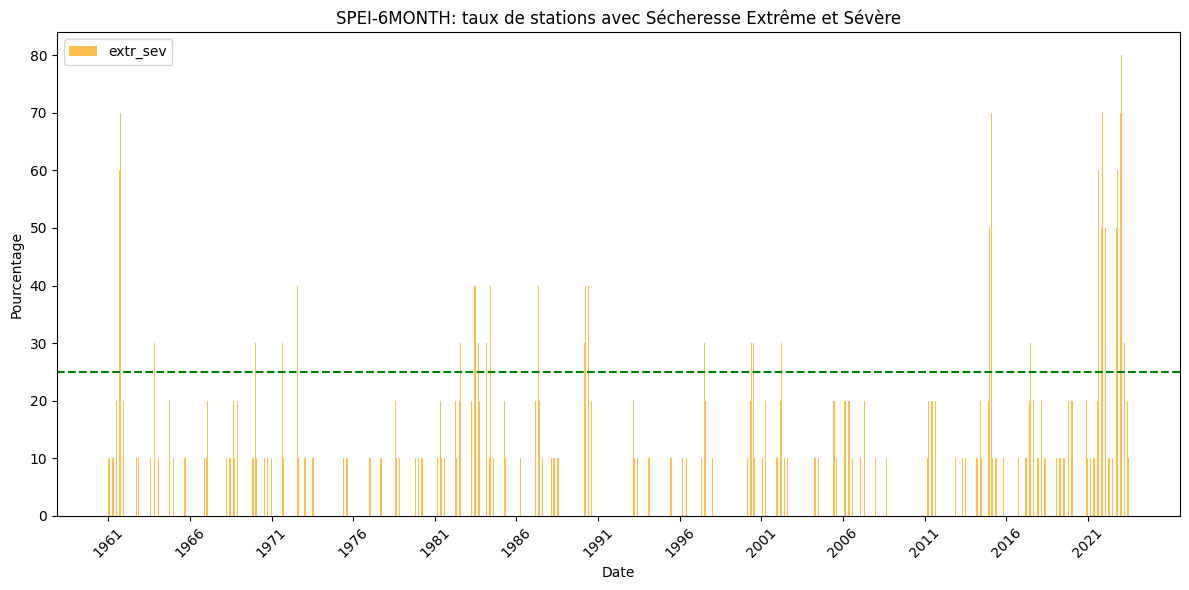

In [85]:
plot_drought_percentages(spei_6mois_spatial,'SPEI-6MONTH')

In [86]:
# Trouvez l'indice de la ligne avec la valeur maximale dans 'Pourcentage Sécheresse extrême'
indice_ligne_max_secheresse = spei_6mois_spatial[f'Pourcentage {Constant.LABEL_II}'].idxmax()
# Obtenez la ligne correspondante à cet indice
ligne_max_secheresse = spei_6mois_spatial.loc[indice_ligne_max_secheresse]
# Maintenant, ligne_max_secheresse_extreme contient la ligne avec la plus haute valeur dans 'Pourcentage Sécheresse extrême'
print(ligne_max_secheresse)

Date                               202305.0
Pourcentage Sécheresse extrême         50.0
Pourcentage Sécheresse sévère          30.0
Pourcentage Sécheresse extr_sev        80.0
Name: 743, dtype: float64
Date                               202305.0
Pourcentage Sécheresse extrême         50.0
Pourcentage Sécheresse sévère          30.0
Pourcentage Sécheresse extr_sev        80.0
Name: 743, dtype: float64


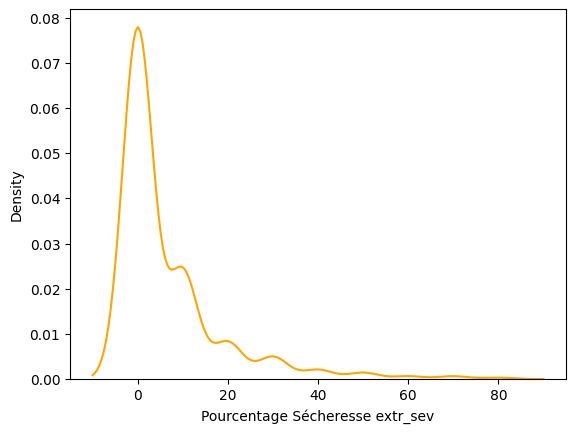

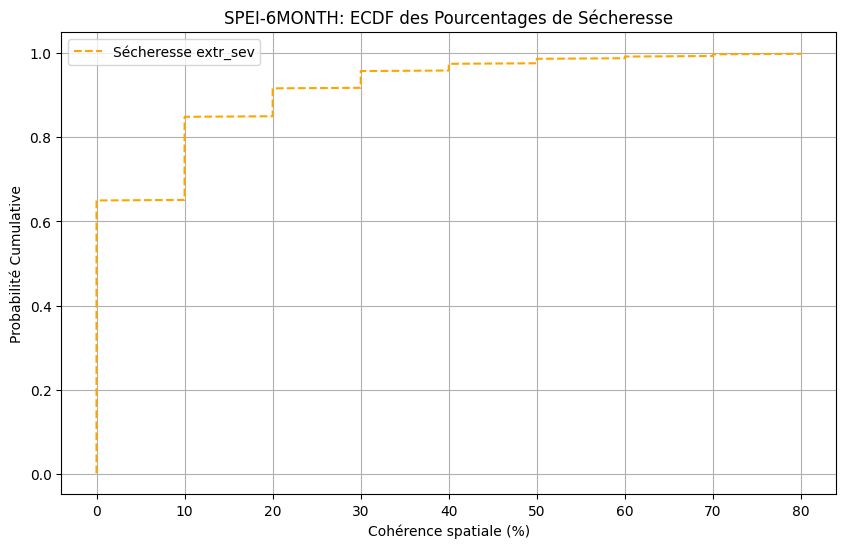

In [87]:
plot_ecdf(spei_3mois_spatial,'SPEI-6MONTH')

In [88]:
#spei_6mois_spatial.to_csv('./spatial_6mois.csv')

#### IV.4- Label des secheresses

In [89]:
spei_6mois_saison=transposition_data(spei_6mois_categorized,'Label Secheresse')

In [90]:
spei_6mois_saison['Date'] = pd.to_datetime(spei_6mois_saison['Date'], format='%Y%m')
saison_pluie_mois['Date'] = pd.to_datetime(saison_pluie_mois['Date'], format='%Y%m')

spei_6mois_fusion = pd.merge(spei_6mois_saison, saison_pluie_mois, on=['Date', 'Station'], how='outer')
spei_6mois_fusion=spei_6mois_fusion[['Station','Date','Label Secheresse','Saison_Pluie','Year','Month']]
spei_6mois_fusion[['Year', 'Month']] = spei_6mois_fusion[['Year', 'Month']].applymap(to_numeric_with_nan)

In [91]:
spei_6mois_fusion.head()

,Station,Date,Label Secheresse,Saison_Pluie,Year,Month
0,Bobo_Dioulasso,1961-01-01,NaN,False,1961,1
1,Bogande,1961-01-01,NaN,False,1961,1
2,Boromo,1961-01-01,NaN,False,1961,1
3,Dedougou,1961-01-01,NaN,False,1961,1
4,Dori,1961-01-01,NaN,False,1961,1


##### IV.4.a- Secheresse extreme

In [92]:
spei_6mois_extr_sev = replace_text_with_one(spei_6mois_fusion,  Constant.LABEL_7, Constant.LABEL_6)

In [93]:
spei_6mois_extr_sev.to_csv(str(Config.FILES_TRAITED_PATH) + '/' + str(Config.DATA_6MON),index=False)

In [94]:
filtered_Bobo_1992 = filter_data_by_year_station(spei_6mois_extr_sev, 1992, 'Bobo_Dioulasso')

In [95]:
filtered_Bobo_1992.head()

,Station,Date,Label Secheresse,Saison_Pluie,Year,Month
3720,Bobo_Dioulasso,1992-01-01,0,False,1992,1
3730,Bobo_Dioulasso,1992-02-01,0,False,1992,2
3740,Bobo_Dioulasso,1992-03-01,0,False,1992,3
3750,Bobo_Dioulasso,1992-04-01,0,True,1992,4
3760,Bobo_Dioulasso,1992-05-01,0,True,1992,5
